PREPARAR MODELO


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [7]:
import os

# Cambiar el directorio de trabajo
os.chdir(r"c:\Users\Alicia\MODELO_MACHINE_LEARNING")

# Leer el archivo directamente
df_input = pd.read_excel("ventas_actualizado.xlsx")

# Verificar el DataFrame
print(df_input.head())

df_input = pd.read_excel("ventas_actualizado.xlsx")


       Fecha  año  trimestre  Mes Zona Geográfica    País  Unidades  Precio  \
0 2021-01-14   21          1    1          ESPAÑA  ESPAÑA      60.0   11.91   
1 2021-03-08   21          1    3          ESPAÑA  ESPAÑA     225.0   12.27   
2 2021-04-26   21          2    4          ESPAÑA  ESPAÑA     335.0   11.91   
3 2021-04-26   21          2    4          ESPAÑA  ESPAÑA      36.0   23.07   
4 2021-04-26   21          2    4          ESPAÑA  ESPAÑA       9.0   23.76   

  Categorias Precio  Total Ventas  \
0             Medio        714.60   
1             Medio       2760.75   
2             Medio       3989.85   
3              Alto        830.52   
4              Alto        213.84   

                                         Descripción  
0   ML.DECK 150 ALVEOLAR CHROMATIC MOKA -2241 NATURE  
1  ML.DECK 150 ALVEOLAR CHROMATIC WENGUE-2204 NATURE  
2   ML.DECK 150 ALVEOLAR CHROMATIC GRIS -2214 NATURE  
3     ML.PERFIL TERMINACION 180X10 GRIS-2214  NATURE  
4     ML.PERFIL TERMINACION

HE RESUMIDO DEMASIADO LOS DATOS, NO VAN A PREDECIR BIEN POR LO QUE VOY A CREAR UN PRODUCTO MAS


In [8]:
# para tener mas filas en la agrupacion:
def categorize(value):
    if value < 3.5:
        return 'Producto 1'
    elif 3.5 <= value < 7.5:
        return 'Producto 2'
    elif 7.5 <= value < 11:
        return 'Producto 3'
    elif 11 <= value < 12.9:
        return 'Producto 4'
    elif 12.9 <= value < 15.5:
        return 'Producto 5'
    else:
        return 'Producto 6'

df_input['product_id'] = df_input['Precio'].apply(categorize)

In [9]:
df_input.columns

Index(['Fecha', 'año', 'trimestre', 'Mes', 'Zona Geográfica', 'País',
       'Unidades', 'Precio', 'Categorias Precio', 'Total Ventas',
       'Descripción', 'product_id'],
      dtype='object')

product_id
Producto 1    5159243.17
Producto 2    1023655.38
Producto 3     965997.13
Producto 4    1040269.81
Producto 5     740944.63
Producto 6     357157.97
Name: Unidades, dtype: float64


<Axes: xlabel='product_id'>

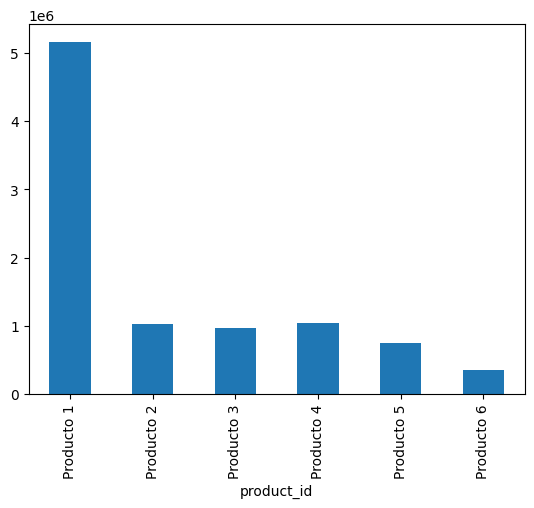

In [10]:
ventas_por_producto = df_input.groupby('product_id')['Unidades'].sum()
print(ventas_por_producto)
ventas_por_producto.plot(kind='bar')


Posible sobreajuste al Producto 1:

Dado que domina los datos, el modelo podría estar "aprendiendo" principalmente a predecir las ventas de este producto, ignorando patrones de los otros productos.
Necesidad de ajustar la estrategia:

Si el objetivo es un modelo generalizado para todos los productos, deberíamos equilibrar las clases o segmentar el análisis.

In [11]:
ventas_por_region_producto = df_input.groupby(['Zona Geográfica', 'product_id'])['Unidades'].sum()
print(ventas_por_region_producto)


Zona Geográfica  product_id
AMÉRICA          Producto 1     389070.80
                 Producto 2      79991.37
                 Producto 3      77255.08
                 Producto 4     153687.97
                 Producto 5      87676.54
                 Producto 6      30371.26
ESPAÑA           Producto 1    3708878.97
                 Producto 2     576145.53
                 Producto 3     731558.18
                 Producto 4     685751.55
                 Producto 5     538481.19
                 Producto 6     298964.33
EUROPA           Producto 1     858510.90
                 Producto 2     365129.23
                 Producto 3     157183.87
                 Producto 4     199775.29
                 Producto 5     114720.40
                 Producto 6      27150.38
RESTO DEL MUNDO  Producto 1     202782.50
                 Producto 2       2389.25
                 Producto 4       1055.00
                 Producto 5         66.50
                 Producto 6        672.00
Name: 

Producto 1 domina en todas las regiones:

En todas las zonas geográficas, el Producto 1 es el más vendido por un amplio margen.
Esto explica su correlación elevada y su impacto en el modelo.
Distribución desigual de productos por región:

En América, las ventas están más distribuidas entre varios productos.
En España, el Producto 1 representa una enorme proporción de las ventas.
En Europa, aunque el Producto 1 sigue dominando, los productos 2, 3, y 4 tienen una presencia significativa.
En Resto del Mundo, las ventas son mínimas para casi todos los productos excepto el Producto 1.
Productos con ventas marginales:

Algunos productos tienen ventas extremadamente bajas, especialmente en regiones como "Resto del Mundo".

In [12]:
# seleccionar columnas relevantes:
df = df_input[['año', 'Mes', 'Zona Geográfica', 'Unidades', 'product_id']]

In [13]:
# renombrar columnas :
df.rename(columns={'año': 'year'}, inplace=True)
df.rename(columns={'Mes': 'month'}, inplace=True)
df.rename(columns={'Zona Geográfica': 'region'}, inplace=True)
df.rename(columns={'Unidades': 'sold_units'}, inplace=True)

C:\Users\Alicia\AppData\Local\Temp\ipykernel_22096\2528278919.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'año': 'year'}, inplace=True)
C:\Users\Alicia\AppData\Local\Temp\ipykernel_22096\2528278919.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Mes': 'month'}, inplace=True)
C:\Users\Alicia\AppData\Local\Temp\ipykernel_22096\2528278919.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [14]:
# agregar informacion:
df = df.groupby(['year', 'month', 'region', 'product_id'])['sold_units'].sum().reset_index()

In [15]:
df

,year,month,region,product_id,sold_units
0,21,1,AMÉRICA,Producto 2,1148.00
1,21,1,AMÉRICA,Producto 4,12.00
2,21,1,ESPAÑA,Producto 1,117284.80
3,21,1,ESPAÑA,Producto 2,9308.55
4,21,1,ESPAÑA,Producto 3,477.70
...,...,...,...,...,...
742,24,12,EUROPA,Producto 1,5720.00
743,24,12,EUROPA,Producto 2,645.00
744,24,12,EUROPA,Producto 3,348.00
745,24,12,EUROPA,Producto 4,6897.00


### ONE-HOT ENCODING

In [16]:
# ----------- preparar datos de entrada:
# Las variables categoricas necesitan one-hot encoding:
columnas_cat = ['product_id', 'region']
encoder = OneHotEncoder(sparse_output=False)
columnas_codificadas = encoder.fit_transform(df[columnas_cat])
df_codificado = pd.DataFrame(columnas_codificadas, columns=encoder.get_feature_names_out(columnas_cat))

# unir a columnas numericas:
columnas_num = ['year', 'month']
X = pd.concat([df[columnas_num], df_codificado], axis=1)

In [17]:
X 
#ahora tengo 6 columnas de product_id, para cada producto
# 4 columnas para region, una para cada region 

,year,month,product_id_Producto 1,product_id_Producto 2,product_id_Producto 3,product_id_Producto 4,product_id_Producto 5,product_id_Producto 6,region_AMÉRICA,region_ESPAÑA,region_EUROPA,region_RESTO DEL MUNDO
0,21,1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,21,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,21,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,21,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,21,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
742,24,12,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
743,24,12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
744,24,12,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
745,24,12,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [18]:
# ---------- preparar target, variable objetivo :
y = df['sold_units']

In [19]:
y

0        1148.00
1          12.00
2      117284.80
3        9308.55
4         477.70
         ...    
742      5720.00
743       645.00
744       348.00
745      6897.00
746       374.00
Name: sold_units, Length: 747, dtype: float64

## ENTRENAMOS MODELO

In [20]:
# Dividir datos de entrada entre datos de entrenamiento y datos de test:
#xtrain-> 70% datos entrenamiento, 30% evaluar el modelo
#random_state-> 42, partes siempre del mismo punto de partida con un valor arbitrario, cada vez el dataset se te va a particionar de distinta forma 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
# Seleccion del mejor modelo - para ahorrar tiempo ajustando hiperparametros a modelos que se ajustan peor al dataset:

modelos = {
    'RegresionLineal': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)  # Añadido XGBoost para evaluación
}

#vemos q modelo tiene el mejor fit con los datos de entrada 
resultados = {}
resultados_mae = {}
resultados_r2 = {}

for nombre_modelo, modelo in modelos.items():
    # 1. Validacion cruzada del modelo (elegir numero de particiones, yo puse 5 por defecto):
    error_rmse = cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    error_mae = cross_val_score(modelo, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    score_r2 = cross_val_score(modelo, X_train, y_train, cv=5, scoring='r2')

    # 2. Calcular RMSE y MAE:
    rmse = np.sqrt(-error_rmse)  # RMSE
    mae = -error_mae  # MAE

    # 3. Guardar las métricas:
    resultados[nombre_modelo] = rmse.mean()
    resultados_mae[nombre_modelo] = mae.mean()
    resultados_r2[nombre_modelo] = score_r2.mean()

# Imprimir resultados de validación cruzada
print("RMSE medio de la validacion cruzada:")
for nombre_modelo, error in resultados.items():
    print(f"{nombre_modelo}: RMSE = {error:.2f}")

print("\nMAE medio de la validacion cruzada:")
for nombre_modelo, error in resultados_mae.items():
    print(f"{nombre_modelo}: MAE = {error:.2f}")

print("\nR^2 medio de la validacion cruzada:")
for nombre_modelo, score in resultados_r2.items():
    print(f"{nombre_modelo}: R^2 = {score:.2f}")

# Seleccionar modelo con mejor RMSE:
mejor_modelo = min(resultados, key=resultados.get)
print(f"\nMejor modelo según RMSE: {mejor_modelo}")
modelo_elegido = modelos[mejor_modelo]


RMSE medio de la validacion cruzada:
RegresionLineal: RMSE = 25719.84
RandomForest: RMSE = 25871.71
XGBoost: RMSE = 30066.08

MAE medio de la validacion cruzada:
RegresionLineal: MAE = 12743.89
RandomForest: MAE = 10269.95
XGBoost: MAE = 12017.19

R^2 medio de la validacion cruzada:
RegresionLineal: R^2 = 0.28
RandomForest: R^2 = 0.08
XGBoost: R^2 = -0.11

Mejor modelo según RMSE: RegresionLineal


R2 relativamente bajo en todos los modelos indica que las variables no explican bien la variabilidad del objetivo.
Los errores altos (RMSE y MAE) sugieren la posibilidad de ruido en los datos o falta de relaciones fuertes entre características y el objetivo.

In [22]:
# Tanto Random Forest como Regresión Lineal tienen un error muy grande y próximo. Esto sugiere que es necesario ajustar los hiperparámetros de ambos modelos por separado para determinar cuál se ajusta mejor.

# --- Ajuste de hiperparámetros para un modelo lineal (Ridge) ---
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV

# Crear un pipeline con estandarización y modelo Ridge
pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

# Buscar hiperparámetros para Ridge
params_ridge = {
    'regressor__alpha': np.logspace(-3, 3, 10)
}

random_search_ridge = RandomizedSearchCV(
    estimator=pipeline_ridge,
    param_distributions=params_ridge,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_ridge.fit(X_train, y_train)
mejor_modelo_ridge = random_search_ridge.best_estimator_
print("Mejor modelo Ridge:", random_search_ridge.best_params_)

# --- Ajuste de hiperparámetros para Random Forest ---
from sklearn.ensemble import RandomForestRegressor

params_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=params_rf,
    n_iter=10,
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_search_rf.fit(X_train, y_train)
mejor_modelo_rf = random_search_rf.best_estimator_
print("Mejor modelo Random Forest:", random_search_rf.best_params_)

# --- Comparación final entre los mejores modelos ---
from sklearn.metrics import mean_squared_error

# Evaluar el mejor modelo Ridge
y_pred_ridge = mejor_modelo_ridge.predict(X_test)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f"RMSE del mejor modelo Ridge: {rmse_ridge:.2f}")

# Evaluar el mejor modelo Random Forest
y_pred_rf = mejor_modelo_rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"RMSE del mejor modelo Random Forest: {rmse_rf:.2f}")

# Seleccionar el mejor modelo según RMSE
if rmse_ridge < rmse_rf:
    mejor_modelo_final = mejor_modelo_ridge
    print("El modelo final seleccionado es Ridge.")
else:
    mejor_modelo_final = mejor_modelo_rf
    print("El modelo final seleccionado es Random Forest.")


Mejor modelo Ridge: {'regressor__alpha': np.float64(46.41588833612773)}
Mejor modelo Random Forest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20}
RMSE del mejor modelo Ridge: 20548.03
RMSE del mejor modelo Random Forest: 13485.12
El modelo final seleccionado es Random Forest.


In [23]:
# --- Evaluación final con validación cruzada ---
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

# Definir métricas
scoring = {
    'RMSE': make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False),
    'R^2': 'r2'
}

# Validación cruzada con el modelo final
resultados_finales = cross_val_score(
    mejor_modelo_rf, X, y, cv=5, scoring='neg_mean_squared_error'
)

# Calcular RMSE promedio
rmse_final = np.sqrt(-resultados_finales.mean())
print(f"\nRMSE promedio del modelo final (validación cruzada): {rmse_final:.2f}")

# Validación cruzada para R^2
resultados_r2 = cross_val_score(mejor_modelo_rf, X, y, cv=5, scoring='r2')
r2_final = resultados_r2.mean()
print(f"R^2 promedio del modelo final (validación cruzada): {r2_final:.2f}")



RMSE promedio del modelo final (validación cruzada): 26516.28
R^2 promedio del modelo final (validación cruzada): -0.20


In [24]:
correlaciones = X.corrwith(y)
print(correlaciones)

year                      0.096982
month                    -0.046037
product_id_Producto 1     0.462266
product_id_Producto 2    -0.064851
product_id_Producto 3    -0.074243
product_id_Producto 4    -0.066696
product_id_Producto 5    -0.096267
product_id_Producto 6    -0.143441
region_AMÉRICA           -0.143394
region_ESPAÑA             0.273287
region_EUROPA            -0.145962
region_RESTO DEL MUNDO   -0.014647
dtype: float64


Dado el desequilibrio en las ventas de los productos (el Producto 1 domina) y las correlaciones débiles en la mayoría de las variables (excepto product_id_Producto 1 y region_ESPAÑA), los resultados actuales sugieren que:
Un modelo único no está capturando bien las diferencias regionales ni la distribución desigual de los productos. 
Un R2 de -0.20 con un RMSE alto indica que el modelo no explica bien la variabilidad en las ventas.
La mejor opción sería segmentar el problema:
Entrenar modelos separados para cada región. Esto permitiría capturar mejor los patrones locales y reducir el impacto del dominio del Producto 1, ya que cada región tiene una distribución de productos diferente.


La mejor opción sería segmentar el problema:
Entrenar modelos separados para cada región. Esto permitiría capturar mejor los patrones locales y reducir el impacto del dominio del Producto 1, ya que cada región tiene una distribución de productos diferente.

In [25]:
df.columns

Index(['year', 'month', 'region', 'product_id', 'sold_units'], dtype='object')

In [26]:
df.head()

,year,month,region,product_id,sold_units
0,21,1,AMÉRICA,Producto 2,1148.00
1,21,1,AMÉRICA,Producto 4,12.00
2,21,1,ESPAÑA,Producto 1,117284.80
3,21,1,ESPAÑA,Producto 2,9308.55
4,21,1,ESPAÑA,Producto 3,477.70


In [27]:
for region in ['region_AMÉRICA', 'region_ESPAÑA', 'region_EUROPA', 'region_RESTO DEL MUNDO']:
    print(f"\n--- Región: {region} ---")
    indices_region = X[region] == 1
    X_region = X[indices_region]
    print("Distribución de productos:")
    productos = X_region[['product_id_Producto 1', 'product_id_Producto 2', 'product_id_Producto 3', 
                          'product_id_Producto 4', 'product_id_Producto 5', 'product_id_Producto 6']].sum()
    print(productos)



--- Región: region_AMÉRICA ---
Distribución de productos:
product_id_Producto 1    21.0
product_id_Producto 2    29.0
product_id_Producto 3    33.0
product_id_Producto 4    31.0
product_id_Producto 5    31.0
product_id_Producto 6    30.0
dtype: float64

--- Región: region_ESPAÑA ---
Distribución de productos:
product_id_Producto 1    47.0
product_id_Producto 2    48.0
product_id_Producto 3    48.0
product_id_Producto 4    48.0
product_id_Producto 5    48.0
product_id_Producto 6    48.0
dtype: float64

--- Región: region_EUROPA ---
Distribución de productos:
product_id_Producto 1    36.0
product_id_Producto 2    46.0
product_id_Producto 3    47.0
product_id_Producto 4    47.0
product_id_Producto 5    43.0
product_id_Producto 6    45.0
dtype: float64

--- Región: region_RESTO DEL MUNDO ---
Distribución de productos:
product_id_Producto 1    11.0
product_id_Producto 2     3.0
product_id_Producto 3     0.0
product_id_Producto 4     3.0
product_id_Producto 5     2.0
product_id_Producto 6  

In [28]:
observaciones_por_region = y.groupby(X[['region_AMÉRICA', 'region_ESPAÑA', 'region_EUROPA', 'region_RESTO DEL MUNDO']].idxmax(axis=1)).size()
print("Número de observaciones por región:")
print(observaciones_por_region)


Número de observaciones por región:
region_AMÉRICA            175
region_ESPAÑA             287
region_EUROPA             264
region_RESTO DEL MUNDO     21
Name: sold_units, dtype: int64


### Segmentamos por región y entrenamos modelos para cada región

In [29]:
from sklearn.metrics import r2_score


In [30]:
#No necesitamos hacer el one-hot encoding de nuevo, porque ya tenemos las columnas dummies en x, 
#lo único que hacemos es usar las columnas dummies de las regiones para filtrar los datos, entrenar modelos por separado, y eliminar estas columnas al pasar los datos al modelo, ya que se vuelven redundantes dentro de cada región.

# Modelos a evaluar
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Resultados finales
resultados_por_region = {}
regiones = ['region_AMÉRICA', 'region_ESPAÑA', 'region_EUROPA', 'region_RESTO DEL MUNDO']

# Iterar sobre cada región
for region in regiones:
    print(f"\n--- Región: {region} ---")
    
    
    indices_region = X[region] == 1  # Seleccionar las filas donde la región es 1
    X_region = X[indices_region].drop(columns=regiones)  # Eliminar columnas de región en \( X \)
    y_region = y[indices_region]  # Variable objetivo
    
    # Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_region, y_region, test_size=0.3, random_state=42)
    
    # Evaluar múltiples modelos
    resultados_region = {}
    for nombre_modelo, modelo in modelos.items():
        # Entrenar el modelo
        modelo.fit(X_train, y_train)
        
        # Predecir y calcular métricas
        y_pred = modelo.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{nombre_modelo} - RMSE: {rmse:.2f}, R^2: {r2:.2f}")
        
        # Guardar resultados del modelo
        resultados_region[nombre_modelo] = {'RMSE': rmse, 'R^2': r2, 'modelo': modelo}
    
    # Seleccionar el mejor modelo para la región según RMSE
    mejor_modelo = min(resultados_region, key=lambda x: resultados_region[x]['RMSE'])
    print(f"Mejor modelo para {region}: {mejor_modelo}")
    
    # Guardar el mejor modelo para la región
    resultados_por_region[region] = {
        'mejor_modelo': mejor_modelo,
        'resultados': resultados_region[mejor_modelo]
    }



--- Región: region_AMÉRICA ---
Regresión Lineal - RMSE: 9626.80, R^2: 0.17
Random Forest - RMSE: 12140.33, R^2: -0.33
XGBoost - RMSE: 16248.97, R^2: -1.38
Mejor modelo para region_AMÉRICA: Regresión Lineal

--- Región: region_ESPAÑA ---
Regresión Lineal - RMSE: 26013.35, R^2: 0.39
Random Forest - RMSE: 29772.11, R^2: 0.20
XGBoost - RMSE: 35284.01, R^2: -0.12
Mejor modelo para region_ESPAÑA: Regresión Lineal

--- Región: region_EUROPA ---
Regresión Lineal - RMSE: 22668.10, R^2: 0.17
Random Forest - RMSE: 19795.56, R^2: 0.37
XGBoost - RMSE: 21651.48, R^2: 0.24
Mejor modelo para region_EUROPA: Random Forest

--- Región: region_RESTO DEL MUNDO ---
Regresión Lineal - RMSE: 25950.26, R^2: -0.23
Random Forest - RMSE: 24195.96, R^2: -0.07
XGBoost - RMSE: 23495.94, R^2: -0.01
Mejor modelo para region_RESTO DEL MUNDO: XGBoost


LA REGION RESTO DEL MUNDO NO LA VOY A ESTUDIAR PORQUE FALTAN DATOS PARA Q PUEDA PREDECIR BIEN

(No comparte patrones de venta con ninguna región para q se pueda combinar) 


In [31]:
# Filtrar datos para excluir RESTO DEL MUNDO
X_filtered = X[X['region_RESTO DEL MUNDO'] == 0].drop(columns=['region_RESTO DEL MUNDO'])
y_filtered = y[X['region_RESTO DEL MUNDO'] == 0]

print(f"Número de observaciones después de excluir RESTO DEL MUNDO: {len(X_filtered)}")



Número de observaciones después de excluir RESTO DEL MUNDO: 726


In [32]:
# Actualizar las regiones a analizar
regiones = ['region_AMÉRICA', 'region_ESPAÑA', 'region_EUROPA']

# Modelos a evaluar
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# Resultados finales
resultados_por_region = {}

# Iterar sobre cada región
for region in regiones:
    print(f"\n--- Región: {region} ---")
    
    # Filtrar los datos para la región específica
    indices_region = X_filtered[region] == 1
    X_region = X_filtered[indices_region].drop(columns=regiones)  # Eliminar columnas de región
    y_region = y_filtered[indices_region]  # Variable objetivo
    
    # Dividir en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X_region, y_region, test_size=0.3, random_state=42)
    
    # Evaluar múltiples modelos
    resultados_region = {}
    for nombre_modelo, modelo in modelos.items():
        # Entrenar el modelo
        modelo.fit(X_train, y_train)
        
        # Predecir y calcular métricas
        y_pred = modelo.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f"{nombre_modelo} - RMSE: {rmse:.2f}, R^2: {r2:.2f}")
        
        # Guardar resultados del modelo
        resultados_region[nombre_modelo] = {'RMSE': rmse, 'R^2': r2, 'modelo': modelo}
    
    # Seleccionar el mejor modelo para la región según RMSE
    mejor_modelo = min(resultados_region, key=lambda x: resultados_region[x]['RMSE'])
    print(f"Mejor modelo para {region}: {mejor_modelo}")
    
    # Guardar el mejor modelo para la región
    resultados_por_region[region] = {
        'mejor_modelo': mejor_modelo,
        'resultados': resultados_region[mejor_modelo]
    }

# Mostrar los resultados finales
print("\nResultados por región:")
for region, resultados in resultados_por_region.items():
    print(f"{region}: Mejor modelo: {resultados['mejor_modelo']}, RMSE: {resultados['resultados']['RMSE']:.2f}, R^2: {resultados['resultados']['R^2']:.2f}")



--- Región: region_AMÉRICA ---
Regresión Lineal - RMSE: 9626.80, R^2: 0.17
Random Forest - RMSE: 12140.33, R^2: -0.33
XGBoost - RMSE: 16248.97, R^2: -1.38
Mejor modelo para region_AMÉRICA: Regresión Lineal

--- Región: region_ESPAÑA ---
Regresión Lineal - RMSE: 26013.35, R^2: 0.39
Random Forest - RMSE: 29772.11, R^2: 0.20
XGBoost - RMSE: 35284.01, R^2: -0.12
Mejor modelo para region_ESPAÑA: Regresión Lineal

--- Región: region_EUROPA ---
Regresión Lineal - RMSE: 22668.10, R^2: 0.17
Random Forest - RMSE: 19795.56, R^2: 0.37
XGBoost - RMSE: 21651.48, R^2: 0.24
Mejor modelo para region_EUROPA: Random Forest

Resultados por región:
region_AMÉRICA: Mejor modelo: Regresión Lineal, RMSE: 9626.80, R^2: 0.17
region_ESPAÑA: Mejor modelo: Regresión Lineal, RMSE: 26013.35, R^2: 0.39
region_EUROPA: Mejor modelo: Random Forest, RMSE: 19795.56, R^2: 0.37


In [33]:
ventas_por_categoria = y.groupby(X.loc[:, ['product_id_Producto 1',
                                           'product_id_Producto 2',
                                           'product_id_Producto 3',
                                           'product_id_Producto 4',
                                           'product_id_Producto 5',
                                           'product_id_Producto 6']].idxmax(axis=1)).sum()
print(ventas_por_categoria)


product_id_Producto 1    5159243.17
product_id_Producto 2    1023655.38
product_id_Producto 3     965997.13
product_id_Producto 4    1040269.81
product_id_Producto 5     740944.63
product_id_Producto 6     357157.97
Name: sold_units, dtype: float64


In [34]:
for region in resultados_por_region:
    mejor_modelo = resultados_por_region[region]['resultados']['modelo']
    if hasattr(mejor_modelo, 'feature_importances_'):  # Solo para Random Forest y XGBoost
        print(f"\nImportancia de variables para {region}:")
        importancias = mejor_modelo.feature_importances_
        for nombre, importancia in zip(X.columns, importancias):
            print(f"{nombre}: {importancia:.4f}")



Importancia de variables para region_EUROPA:
year: 0.2547
month: 0.5465
product_id_Producto 1: 0.1341
product_id_Producto 2: 0.0415
product_id_Producto 3: 0.0040
product_id_Producto 4: 0.0043
product_id_Producto 5: 0.0018
product_id_Producto 6: 0.0131


LOS MODELOS SIGUEN DANDO R2 MUY BAJAS, POR LO QUE VOY A AJUSTAR LAS CATEGORIAS

primero voy a ajustar los rangos de precios actuales en mas categorias

In [35]:
df.columns

Index(['year', 'month', 'region', 'product_id', 'sold_units'], dtype='object')

In [36]:
#VOY A CREAR 10 EN VEZ DE 6


# Crear nuevas categorías basadas en ventas totales (cuantiles)
df['new_product_id'] = pd.qcut(df['sold_units'], q=10, labels=[f'Producto {i+1}' for i in range(10)], duplicates='drop')

# Convertir a variables dummy para incluir en el modelo
df = pd.get_dummies(df, columns=['new_product_id'], drop_first=True)


In [37]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Dividir por región
regiones = df['region'].unique()
resultados_por_region = {}

for region in regiones:
    print(f"\n--- Región: {region} ---")
    datos_region = df[df['region'] == region]
    X = datos_region.drop(columns=['region', 'sold_units', 'product_id'])
    y = datos_region['sold_units']
    
    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Modelo base: Random Forest con optimización
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search_rf = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_distributions=param_grid_rf,
        n_iter=10,
        scoring='neg_mean_squared_error',
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    grid_search_rf.fit(X_train, y_train)
    best_rf = grid_search_rf.best_estimator_

    # Evaluar el modelo optimizado
    y_pred_rf = best_rf.predict(X_test)
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)
    print(f"Random Forest Optimizado - RMSE: {rmse_rf:.2f}, R^2: {r2_rf:.2f}")

    # Guardar resultados
    resultados_por_region[region] = {
        'mejor_modelo': 'Random Forest',
        'RMSE': rmse_rf,
        'R^2': r2_rf
    }

# Mostrar resultados finales por región
print("\nResultados finales por región:")
for region, resultados in resultados_por_region.items():
    print(f"{region}: Mejor modelo: {resultados['mejor_modelo']}, RMSE: {resultados['RMSE']:.2f}, R^2: {resultados['R^2']:.2f}")



--- Región: AMÉRICA ---
Random Forest Optimizado - RMSE: 6219.33, R^2: 0.65

--- Región: ESPAÑA ---
Random Forest Optimizado - RMSE: 25941.27, R^2: 0.40

--- Región: EUROPA ---
Random Forest Optimizado - RMSE: 15070.50, R^2: 0.63

--- Región: RESTO DEL MUNDO ---
Random Forest Optimizado - RMSE: 21326.68, R^2: 0.17

Resultados finales por región:
AMÉRICA: Mejor modelo: Random Forest, RMSE: 6219.33, R^2: 0.65
ESPAÑA: Mejor modelo: Random Forest, RMSE: 25941.27, R^2: 0.40
EUROPA: Mejor modelo: Random Forest, RMSE: 15070.50, R^2: 0.63
RESTO DEL MUNDO: Mejor modelo: Random Forest, RMSE: 21326.68, R^2: 0.17


In [38]:
print(df.columns)


Index(['year', 'month', 'region', 'product_id', 'sold_units',
       'new_product_id_Producto 2', 'new_product_id_Producto 3',
       'new_product_id_Producto 4', 'new_product_id_Producto 5',
       'new_product_id_Producto 6', 'new_product_id_Producto 7',
       'new_product_id_Producto 8', 'new_product_id_Producto 9',
       'new_product_id_Producto 10'],
      dtype='object')


In [39]:
# Verificar columnas duplicadas
duplicated_columns = df.columns[df.columns.duplicated()]
print(f"Columnas duplicadas: {duplicated_columns}")

# Eliminar columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]


Columnas duplicadas: Index([], dtype='object')


In [42]:
# Obtener la importancia de las características
importancias = best_rf.feature_importances_
importancia_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 10 variables más importantes
print(importancia_df.head(10))


                      Variable  Importancia
0                         year     0.327133
10  new_product_id_Producto 10     0.322624
1                        month     0.317249
3    new_product_id_Producto 3     0.022156
2    new_product_id_Producto 2     0.010837
5    new_product_id_Producto 5     0.000000
4    new_product_id_Producto 4     0.000000
6    new_product_id_Producto 6     0.000000
7    new_product_id_Producto 7     0.000000
8    new_product_id_Producto 8     0.000000


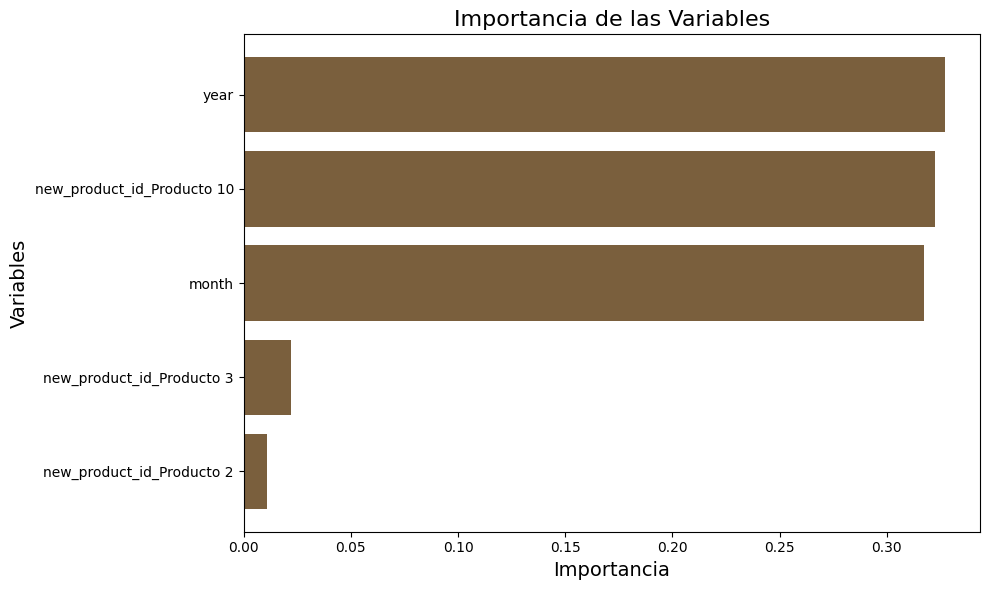

In [46]:
import matplotlib.pyplot as plt

# Filtrar las variables con importancia mayor a 0
importancia_relevante = importancia_df[importancia_df['Importancia'] > 0]

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(importancia_relevante['Variable'], importancia_relevante['Importancia'], color='#7A5F3D')  # Color inspirado en Tarimatec
plt.xlabel('Importancia', fontsize=14)
plt.ylabel('Variables', fontsize=14)
plt.title('Importancia de las Variables', fontsize=16)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [47]:
# Obtener la importancia de las características
importancias = best_rf.feature_importances_
importancia_df = pd.DataFrame({
    'Variable': X_train.columns,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False)

# Mostrar las 10 variables más importantes
print(importancia_df.head(10))

                      Variable  Importancia
0                         year     0.327133
10  new_product_id_Producto 10     0.322624
1                        month     0.317249
3    new_product_id_Producto 3     0.022156
2    new_product_id_Producto 2     0.010837
5    new_product_id_Producto 5     0.000000
4    new_product_id_Producto 4     0.000000
6    new_product_id_Producto 6     0.000000
7    new_product_id_Producto 7     0.000000
8    new_product_id_Producto 8     0.000000


In [49]:


# Inicializar estructura para almacenar resultados
resultados_por_region = {}

# Iterar por región
for region in df['region'].unique():
    print(f"\n--- Región: {region} ---")
    datos_region = df[df['region'] == region]
    X = datos_region.drop(columns=['region', 'sold_units', 'product_id'])
    y = datos_region['sold_units']
    
    # Dividir en entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Modelo base: Random Forest con optimización
    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    grid_search_rf = RandomizedSearchCV(
        RandomForestRegressor(random_state=42),
        param_distributions=param_grid_rf,
        n_iter=10,
        scoring='neg_mean_squared_error',
        cv=3,
        random_state=42,
        n_jobs=-1
    )
    grid_search_rf.fit(X_train, y_train)
    best_rf = grid_search_rf.best_estimator_

    # Realizar predicciones
    y_pred_rf = best_rf.predict(X_test)

    # Calcular métricas
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    r2_rf = r2_score(y_test, y_pred_rf)

    # Calcular totales reales y predichos
    total_reales = y_test.sum()
    total_predichos = y_pred_rf.sum()

    # Imprimir resultados para la región
    print(f"Totales - Reales: {total_reales:.2f}, Predichos: {total_predichos:.2f}")
    print(f"Random Forest Optimizado - RMSE: {rmse_rf:.2f}, R^2: {r2_rf:.2f}")

    # Guardar resultados
    resultados_por_region[region] = {
        'Total_Reales': total_reales,
        'Total_Predichos': total_predichos,
        'RMSE': rmse_rf,
        'R^2': r2_rf
    }

# Mostrar totales finales por región
print("\nTotales finales por región:")
for region, resultados in resultados_por_region.items():
    print(f"{region}: Totales Reales: {resultados['Total_Reales']:.2f}, Totales Predichos: {resultados['Total_Predichos']:.2f}")



--- Región: AMÉRICA ---
Totales - Reales: 230042.37, Predichos: 276994.44
Random Forest Optimizado - RMSE: 6219.33, R^2: 0.65

--- Región: ESPAÑA ---
Totales - Reales: 2106046.35, Predichos: 2403889.64
Random Forest Optimizado - RMSE: 25941.27, R^2: 0.40

--- Región: EUROPA ---
Totales - Reales: 752463.27, Predichos: 803955.70
Random Forest Optimizado - RMSE: 15070.50, R^2: 0.63

--- Región: RESTO DEL MUNDO ---
Totales - Reales: 109678.25, Predichos: 53579.33
Random Forest Optimizado - RMSE: 21326.68, R^2: 0.17

Totales finales por región:
AMÉRICA: Totales Reales: 230042.37, Totales Predichos: 276994.44
ESPAÑA: Totales Reales: 2106046.35, Totales Predichos: 2403889.64
EUROPA: Totales Reales: 752463.27, Totales Predichos: 803955.70
RESTO DEL MUNDO: Totales Reales: 109678.25, Totales Predichos: 53579.33


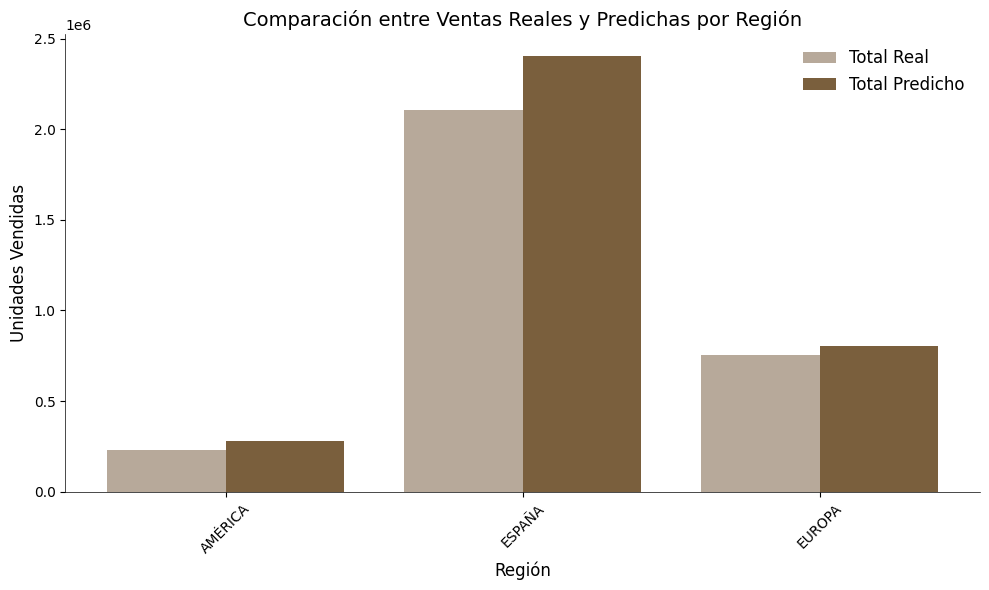

In [54]:
import matplotlib.pyplot as plt
import pandas as pd

# Datos de totales reales y predichos por región
datos = {
    'Región': ['AMÉRICA', 'ESPAÑA', 'EUROPA'],
    'Ventas_Reales': [230042.37, 2106046.35, 752463.27],
    'Ventas_Predichas': [276994.44, 2403889.64, 803955.70]
}

# Convertir los datos a un DataFrame
df_resultados = pd.DataFrame(datos)

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
x = range(len(df_resultados['Región']))  # Posiciones de las barras
bar_width = 0.4  # Ancho de las barras

# Barras de ventas reales
plt.bar([pos - bar_width/2 for pos in x], 
        df_resultados['Ventas_Reales'], 
        width=bar_width, 
        label='Total Real', 
        color='#B7A99A')  # Color gris claro (estilo Tarimatec)

# Barras de ventas predichas
plt.bar([pos + bar_width/2 for pos in x], 
        df_resultados['Ventas_Predichas'], 
        width=bar_width, 
        label='Total Predicho', 
        color='#7A5F3D')  # Color marrón oscuro (estilo Tarimatec)

# Personalizar el gráfico
plt.title('Comparación entre Ventas Reales y Predichas por Región', fontsize=14)
plt.xlabel('Región', fontsize=12)
plt.ylabel('Unidades Vendidas', fontsize=12)
plt.xticks(x, df_resultados['Región'], rotation=45)  # Etiquetas de las regiones
plt.legend(fontsize=12, frameon=False)  # Sin marco en la leyenda

# Quitar fondo y bordes adicionales
plt.grid(False)
plt.gca().set_facecolor('white')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_linewidth(0.5)
plt.gca().spines['bottom'].set_linewidth(0.5)

# Mostrar el gráfico
plt.tight_layout()
plt.show()
